In [1]:
# import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web

%matplotlib inline

# Import Statsmodels

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4
# Select start and end dates
#start = datetime.datetime(2000, 1, 1)
#end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [3]:
d_parser = lambda x: pd.datetime.strptime(x, '%Y')
df = pd.read_csv('bank-2.csv', parse_dates=['Year'], date_parser=d_parser)
df

C:\Users\HP\AppData\Local\Temp/ipykernel_14060/1364450223.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  d_parser = lambda x: pd.datetime.strptime(x, '%Y')


,Year,ROE,Liquidity Ratio,Bond Yield Spread,Economy Growth(Log RGDP),PCE
0,2010-01-01,0.058665,0.77,2.69,9.668271,1.055590
1,2011-01-01,0.078710,0.72,1.64,9.683383,1.975812
2,2012-01-01,0.087681,0.70,1.53,9.698923,1.689025
3,2013-01-01,0.094680,0.70,2.66,9.723928,1.657991
4,2014-01-01,0.087422,0.70,1.50,9.749242,1.469712
5,2015-01-01,0.090871,0.72,1.21,9.767816,1.128692
6,2016-01-01,0.090419,0.72,1.25,9.787659,1.828415
7,2017-01-01,0.083208,0.72,0.51,9.814475,1.720768
8,2018-01-01,0.117590,0.73,0.21,9.837416,2.056652
9,2019-01-01,0.109607,0.72,0.34,9.862786,1.637749


In [4]:
df['Date_at_year_month'] = df['Year'].dt.strftime('%Y-%m')

In [5]:
df.head()

,Year,ROE,Liquidity Ratio,Bond Yield Spread,Economy Growth(Log RGDP),PCE,Date_at_year_month
0,2010-01-01,0.058665,0.77,2.69,9.668271,1.055590,2010-01
1,2011-01-01,0.078710,0.72,1.64,9.683383,1.975812,2011-01
2,2012-01-01,0.087681,0.70,1.53,9.698923,1.689025,2012-01
3,2013-01-01,0.094680,0.70,2.66,9.723928,1.657991,2013-01
4,2014-01-01,0.087422,0.70,1.50,9.749242,1.469712,2014-01


In [6]:
column_names = {'Date_at_year_month':'DATE',
                'ROE':'ROE',
                'Liquidity Ratio': 'LR',
                'Bond Yield Spread':'BY',
                'Economy Growth(Log RGDP)':'RGDP', 
                'PCE':'PCE'}

# rename columns
df = df.rename(columns = column_names)

df

,Year,ROE,LR,BY,RGDP,PCE,DATE
0,2010-01-01,0.058665,0.77,2.69,9.668271,1.055590,2010-01
1,2011-01-01,0.078710,0.72,1.64,9.683383,1.975812,2011-01
2,2012-01-01,0.087681,0.70,1.53,9.698923,1.689025,2012-01
3,2013-01-01,0.094680,0.70,2.66,9.723928,1.657991,2013-01
4,2014-01-01,0.087422,0.70,1.50,9.749242,1.469712,2014-01
5,2015-01-01,0.090871,0.72,1.21,9.767816,1.128692,2015-01
6,2016-01-01,0.090419,0.72,1.25,9.787659,1.828415,2016-01
7,2017-01-01,0.083208,0.72,0.51,9.814475,1.720768,2017-01
8,2018-01-01,0.117590,0.73,0.21,9.837416,2.056652,2018-01
9,2019-01-01,0.109607,0.72,0.34,9.862786,1.637749,2019-01


In [7]:
df = df.drop(['Year'], axis = 1)
df

,ROE,LR,BY,RGDP,PCE,DATE
0,0.058665,0.77,2.69,9.668271,1.055590,2010-01
1,0.078710,0.72,1.64,9.683383,1.975812,2011-01
2,0.087681,0.70,1.53,9.698923,1.689025,2012-01
3,0.094680,0.70,2.66,9.723928,1.657991,2013-01
4,0.087422,0.70,1.50,9.749242,1.469712,2014-01
5,0.090871,0.72,1.21,9.767816,1.128692,2015-01
6,0.090419,0.72,1.25,9.787659,1.828415,2016-01
7,0.083208,0.72,0.51,9.814475,1.720768,2017-01
8,0.117590,0.73,0.21,9.837416,2.056652,2018-01
9,0.109607,0.72,0.34,9.862786,1.637749,2019-01


In [8]:
df = df.set_index('DATE')
df

,ROE,LR,BY,RGDP,PCE
DATE,,,,,
2010-01,0.058665,0.77,2.69,9.668271,1.055590
2011-01,0.078710,0.72,1.64,9.683383,1.975812
2012-01,0.087681,0.70,1.53,9.698923,1.689025
2013-01,0.094680,0.70,2.66,9.723928,1.657991
2014-01,0.087422,0.70,1.50,9.749242,1.469712
2015-01,0.090871,0.72,1.21,9.767816,1.128692
2016-01,0.090419,0.72,1.25,9.787659,1.828415
2017-01,0.083208,0.72,0.51,9.814475,1.720768
2018-01,0.117590,0.73,0.21,9.837416,2.056652


In [9]:
data = df
data

,ROE,LR,BY,RGDP,PCE
DATE,,,,,
2010-01,0.058665,0.77,2.69,9.668271,1.055590
2011-01,0.078710,0.72,1.64,9.683383,1.975812
2012-01,0.087681,0.70,1.53,9.698923,1.689025
2013-01,0.094680,0.70,2.66,9.723928,1.657991
2014-01,0.087422,0.70,1.50,9.749242,1.469712
2015-01,0.090871,0.72,1.21,9.767816,1.128692
2016-01,0.090419,0.72,1.25,9.787659,1.828415
2017-01,0.083208,0.72,0.51,9.814475,1.720768
2018-01,0.117590,0.73,0.21,9.837416,2.056652


In [10]:
data.isnull().sum()

ROE     0
LR      0
BY      0
RGDP    0
PCE     0
dtype: int64

In [11]:
#1st diff

data_diff = data.diff().dropna()
data_diff

,ROE,LR,BY,RGDP,PCE
DATE,,,,,
2011-01,0.020045,-0.05,-1.05,0.015112,0.920222
2012-01,0.008971,-0.02,-0.11,0.015539,-0.286787
2013-01,0.006999,0.00,1.13,0.025005,-0.031034
2014-01,-0.007258,0.00,-1.16,0.025314,-0.188279
2015-01,0.003449,0.02,-0.29,0.018573,-0.341020
2016-01,-0.000452,0.00,0.04,0.019844,0.699723
2017-01,-0.007211,0.00,-0.74,0.026816,-0.107647
2018-01,0.034382,0.01,-0.30,0.022941,0.335884
2019-01,-0.007983,-0.01,0.13,0.025370,-0.418903


In [12]:
X = data_diff["ROE"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["LR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["BY"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["RGDP"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
X = data_diff["PCE"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -3.855736
p-value: 0.002386
Critical Values:
	1%: -4.665
	5%: -3.367
	10%: -2.803
Reject Ho - Time Series is Stationary
ADF Statistic: -3.644219
p-value: 0.004970
Critical Values:
	1%: -4.665
	5%: -3.367
	10%: -2.803
Reject Ho - Time Series is Stationary
ADF Statistic: -4.438343
p-value: 0.000254
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844
Reject Ho - Time Series is Stationary
ADF Statistic: -3.847213
p-value: 0.002460
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844
Reject Ho - Time Series is Stationary
ADF Statistic: -4.958878
p-value: 0.000027
Critical Values:
	1%: -4.665
	5%: -3.367
	10%: -2.803
Reject Ho - Time Series is Stationary


,ROE,LR,BY,RGDP,PCE
ROE,1.000000,-0.178519,0.007120,-0.433398,0.514276
LR,-0.178519,1.000000,0.282712,0.503867,-0.472432
BY,0.007120,0.282712,1.000000,0.164398,-0.205895
RGDP,-0.433398,0.503867,0.164398,1.000000,-0.405098
PCE,0.514276,-0.472432,-0.205895,-0.405098,1.000000


<AxesSubplot:>

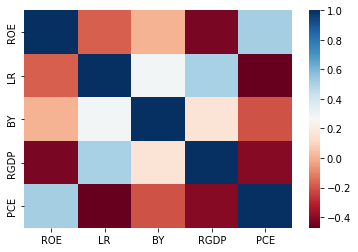

In [47]:
# calculate the correlation matrix
corr = data_diff.corr()

# display the correlation matrix
display(corr)

# plot the correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

In [48]:
# define two data frames one before the drop and one after the drop
data_diff_before = data_diff
#data_diff_after = data_diff.drop(['gdp_growth','birth_rate', 'final_consum_growth','gross_capital_formation'], axis = 1)

# the VFI does expect a constant term in the data, so we need to add one using the add_constant method
X1 = sm.tools.add_constant(data_diff_before)
#X2 = sm.tools.add_constant(data_diff_after)

# create the series for both
series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)
#series_after = pd.Series([variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])], index=X2.columns)

# display the series
print('DATA BEFORE')
print('-'*100)
display(series_before)

#print('DATA AFTER')
#print('-'*100)
#display(series_after)

DATA BEFORE
----------------------------------------------------------------------------------------------------


const    48.689338
ROE       1.585920
LR        1.638757
BY        1.113922
RGDP      1.607340
PCE       1.738352
dtype: float64

In [13]:
#Summary

# get the summary
desc_df = data_diff.describe()

# add the standard deviation metric
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

# display it
desc_df

,ROE,LR,BY,RGDP,PCE
count,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.005660,-0.005556,-0.261111,0.021613,0.064684
std,0.014167,0.020069,0.694954,0.004468,0.478749
min,-0.007983,-0.050000,-1.160000,0.015112,-0.418903
25%,-0.007211,-0.010000,-0.740000,0.018573,-0.286787
50%,0.003449,0.000000,-0.290000,0.022941,-0.107647
75%,0.008971,0.000000,0.040000,0.025314,0.335884
max,0.034382,0.020000,1.130000,0.026816,0.920222
+3_std,0.048161,0.054652,1.823751,0.035016,1.500930
-3_std,-0.036840,-0.065764,-2.345973,0.008210,-1.371562


In [14]:
data_diff = data_diff.astype(float)

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.transforms as mtransforms
import datetime
import math

In [16]:
#Build the model

X = data_diff.drop('ROE', axis = 1)
Y = data_diff[['ROE']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)


regression_model = LinearRegression()


regression_model.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

LinearRegression()

In [17]:
#Exploring the Output
# let's grab the coefficient of our model and the intercept
intercept = regression_model.intercept_[0]
coefficent = regression_model.coef_[0][0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

# loop through the dictionary and print the data
for coef in zip(X.columns, regression_model.coef_[0]):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

The intercept for our model is 0.03331
----------------------------------------------------------------------------------------------------
The Coefficient for LR is 0.18
The Coefficient for BY is -0.0011
The Coefficient for RGDP is -1.3
The Coefficient for PCE is 0.014


In [18]:
# define our intput
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

In [19]:
# Get multiple predictions
y_predict = regression_model.predict(X_test)

# Show the first 5 predictions
y_predict[:5]

array([[-0.00826692],
       [-0.00173084]])

In [20]:
# define our intput
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

In [21]:
#Checking for Heteroscedasticity

_, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity.")

else:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity.")

0.2558840760574691 0.3646270135766473
----------------------------------------------------------------------------------------------------
For the Breusch-Pagan's Test
The p-value was 0.2559
We fail to reject the null hypthoesis, so there is no heterosecdasticity.


In [22]:
# OLS

In [24]:
reg_data.corr()

,ROE,LR,BY,RGDP,PCE
ROE,1.000000,-0.431826,-0.684334,0.782072,0.537400
LR,-0.431826,1.000000,0.142833,-0.134539,-0.380639
BY,-0.684334,0.142833,1.000000,-0.864834,-0.459587
RGDP,0.782072,-0.134539,-0.864834,1.000000,0.325460
PCE,0.537400,-0.380639,-0.459587,0.325460,1.000000


In [25]:
reg_data.describe().round(2)

,ROE,LR,BY,RGDP,PCE
count,10.00,10.00,10.00,10.00,10.00
mean,0.09,0.72,1.35,9.76,1.62
std,0.02,0.02,0.86,0.07,0.33
min,0.06,0.70,0.21,9.67,1.06
25%,0.08,0.70,0.68,9.71,1.51
50%,0.09,0.72,1.38,9.76,1.67
75%,0.09,0.72,1.61,9.81,1.80
max,0.12,0.77,2.69,9.86,2.06


In [26]:
y = reg_data[y_var]
X = reg_data[x_vars]
X["Constant"]=1
results = sm.OLS(y,X).fit()
results.summary()

C:\Users\HP\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROE   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     4.057
Date:                Wed, 13 Apr 2022   Prob (F-statistic):             0.0784
Time:                        21:20:20   Log-Likelihood:                 34.850
No. Observations:                  10   AIC:                            -59.70
Df Residuals:                       5   BIC:                            -58.19
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
LR            -0.1952      0.185     -1.056      0.339      -0.670       0.280
BY             0.0033      0.009      0.377      0.722      -0.019       0.026
RGDP           0.1981      0.107      1.859      0.122      -0.076       0.472
PCE            0.0127      0.013      0.968      0.377      -0.021       0.046
Constant      -1.7280      1.075     -1.608      0.169      -4.491       1.035
==============================================================================
Omnibus:                        2.036   Durbin-Watson:                   2.409
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                0.532
Skew:                          -0.560   Prob(JB):                        0.766
Kurtosis:                       3.152   Cond. No.                     3.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
df = data_diff

In [28]:
##Testing Causation using Granger’s Causality Test

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=2
test = 'ssr_chi2test'
def grangers_causation_matrix(data_diff, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data_diff[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,ROE_x,LR_x,BY_x,RGDP_x,PCE_x
ROE_y,1.0000,0.0000,0.0873,0.7783,0.0000
LR_y,0.0000,1.0000,0.0000,0.1019,0.0000
BY_y,0.0000,0.0000,1.0000,0.0531,0.0437
RGDP_y,0.0004,0.2303,0.0050,1.0000,0.0002
PCE_y,0.0543,0.1196,0.2384,0.4158,1.0000


In [29]:
## Partial Correlation

import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)
residuals

,ROE,LR,BY,RGDP,PCE
DATE,,,,,
2011-01,0.002754,-0.019726,-0.320580,-0.000388,0.194187
2012-01,0.003252,-0.010233,0.201922,-0.004456,-0.522961
2013-01,0.002648,-0.008072,1.285612,0.002607,0.038697
2014-01,-0.003887,0.001763,-0.936352,0.001972,-0.071093
2015-01,-0.003308,0.025504,-0.256230,-0.005734,-0.163426
2016-01,-0.018713,0.019347,0.479520,-0.002946,0.792886
2017-01,-0.004253,-0.001410,-0.512289,0.003372,0.042118
2018-01,0.024200,0.009675,-0.314099,0.003094,-0.029270
2019-01,-0.002693,-0.016847,0.372496,0.002479,-0.281137


In [30]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

,ROE,LR,BY,RGDP,PCE
ROE,1.00,0.20,0.13,-0.35,0.47
LR,0.20,1.00,0.16,0.42,-0.37
BY,0.13,0.16,1.00,0.05,-0.13
RGDP,-0.35,0.42,0.05,1.00,-0.02
PCE,0.47,-0.37,-0.13,-0.02,1.00


In [31]:
# !pip install pingouin
import pingouin
df.pcorr().round(2)

,ROE,LR,BY,RGDP,PCE
ROE,1.00,0.20,0.13,-0.35,0.47
LR,0.20,1.00,0.16,0.42,-0.37
BY,0.13,0.16,1.00,0.05,-0.13
RGDP,-0.35,0.42,0.05,1.00,-0.02
PCE,0.47,-0.37,-0.13,-0.02,1.00


In [32]:
residuals

,ROE,LR,BY,RGDP,PCE
DATE,,,,,
2011-01,0.002754,-0.019726,-0.320580,-0.000388,0.194187
2012-01,0.003252,-0.010233,0.201922,-0.004456,-0.522961
2013-01,0.002648,-0.008072,1.285612,0.002607,0.038697
2014-01,-0.003887,0.001763,-0.936352,0.001972,-0.071093
2015-01,-0.003308,0.025504,-0.256230,-0.005734,-0.163426
2016-01,-0.018713,0.019347,0.479520,-0.002946,0.792886
2017-01,-0.004253,-0.001410,-0.512289,0.003372,0.042118
2018-01,0.024200,0.009675,-0.314099,0.003094,-0.029270
2019-01,-0.002693,-0.016847,0.372496,0.002479,-0.281137


In [33]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

,ROE,LR,BY,RGDP,PCE
ROE,NaN,0.59,0.72,0.32,0.18
LR,0.59,NaN,0.65,0.23,0.30
BY,0.72,0.65,NaN,0.88,0.72
RGDP,0.32,0.23,0.88,NaN,0.96
PCE,0.18,0.30,0.72,0.96,NaN


## DAG

In [34]:
import pingouin
from pgmpy.estimators import PC
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx

In [35]:
## Estimating a Directed Acyclic Graph
p_val = .01
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys())-2


model = c.estimate(return_type = "pdag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

  0%|          | 0/3 [00:00<?, ?it/s]

In [36]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
## Partial Correlation

import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)
residuals

,ROE,LR,BY,RGDP,PCE
DATE,,,,,
2011-01,0.002754,-0.019726,-0.320580,-0.000388,0.194187
2012-01,0.003252,-0.010233,0.201922,-0.004456,-0.522961
2013-01,0.002648,-0.008072,1.285612,0.002607,0.038697
2014-01,-0.003887,0.001763,-0.936352,0.001972,-0.071093
2015-01,-0.003308,0.025504,-0.256230,-0.005734,-0.163426
2016-01,-0.018713,0.019347,0.479520,-0.002946,0.792886
2017-01,-0.004253,-0.001410,-0.512289,0.003372,0.042118
2018-01,0.024200,0.009675,-0.314099,0.003094,-0.029270
2019-01,-0.002693,-0.016847,0.372496,0.002479,-0.281137


In [38]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

,ROE,LR,BY,RGDP,PCE
ROE,1.00,0.20,0.13,-0.35,0.47
LR,0.20,1.00,0.16,0.42,-0.37
BY,0.13,0.16,1.00,0.05,-0.13
RGDP,-0.35,0.42,0.05,1.00,-0.02
PCE,0.47,-0.37,-0.13,-0.02,1.00


In [39]:
# !pip install pingouin
import pingouin
df.pcorr().round(2)

,ROE,LR,BY,RGDP,PCE
ROE,1.00,0.20,0.13,-0.35,0.47
LR,0.20,1.00,0.16,0.42,-0.37
BY,0.13,0.16,1.00,0.05,-0.13
RGDP,-0.35,0.42,0.05,1.00,-0.02
PCE,0.47,-0.37,-0.13,-0.02,1.00


In [40]:
residuals

,ROE,LR,BY,RGDP,PCE
DATE,,,,,
2011-01,0.002754,-0.019726,-0.320580,-0.000388,0.194187
2012-01,0.003252,-0.010233,0.201922,-0.004456,-0.522961
2013-01,0.002648,-0.008072,1.285612,0.002607,0.038697
2014-01,-0.003887,0.001763,-0.936352,0.001972,-0.071093
2015-01,-0.003308,0.025504,-0.256230,-0.005734,-0.163426
2016-01,-0.018713,0.019347,0.479520,-0.002946,0.792886
2017-01,-0.004253,-0.001410,-0.512289,0.003372,0.042118
2018-01,0.024200,0.009675,-0.314099,0.003094,-0.029270
2019-01,-0.002693,-0.016847,0.372496,0.002479,-0.281137


In [41]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

,ROE,LR,BY,RGDP,PCE
ROE,NaN,0.59,0.72,0.32,0.18
LR,0.59,NaN,0.65,0.23,0.30
BY,0.72,0.65,NaN,0.88,0.72
RGDP,0.32,0.23,0.88,NaN,0.96
PCE,0.18,0.30,0.72,0.96,NaN


OutEdgeView([])

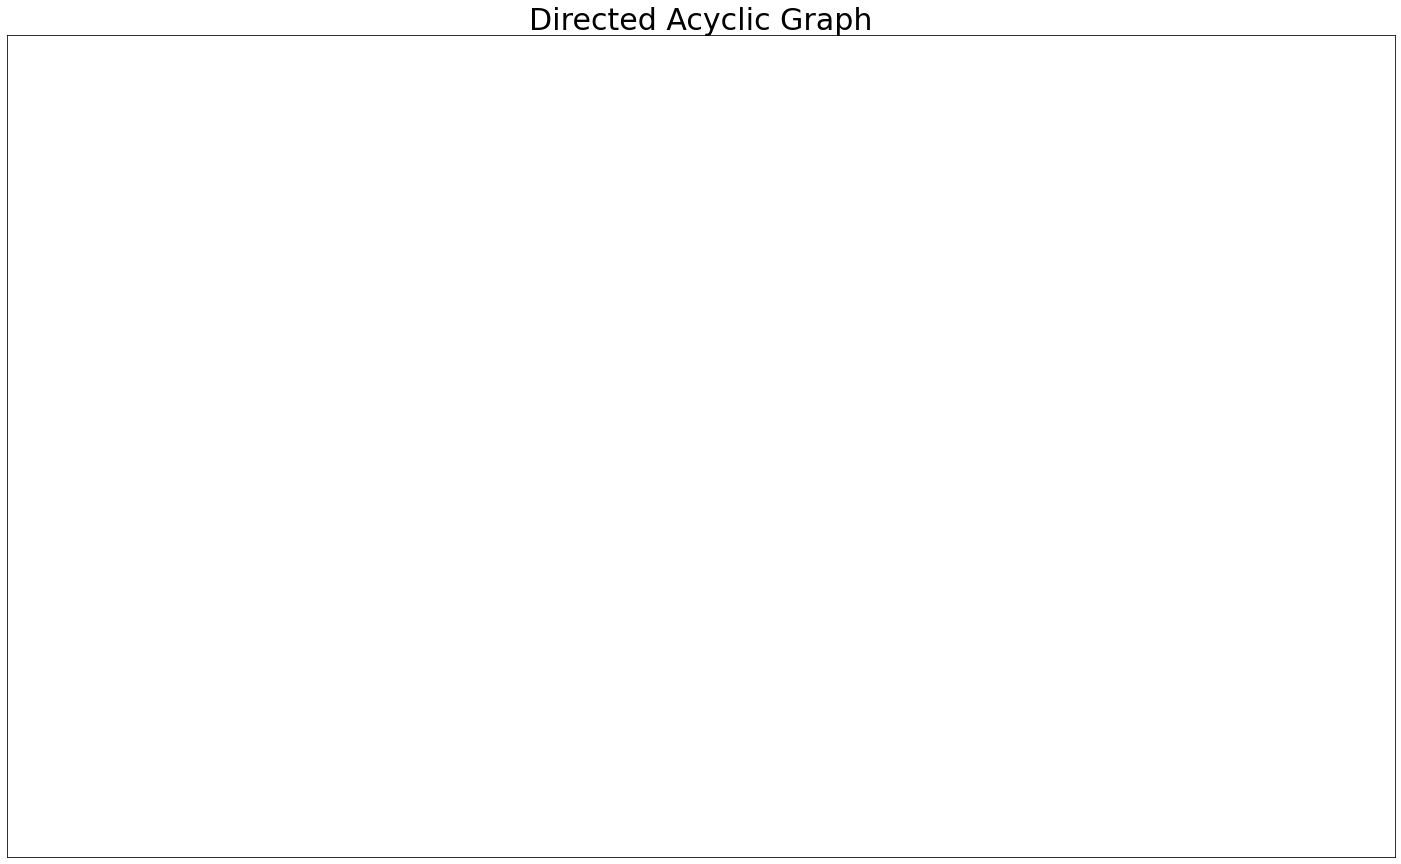

In [42]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

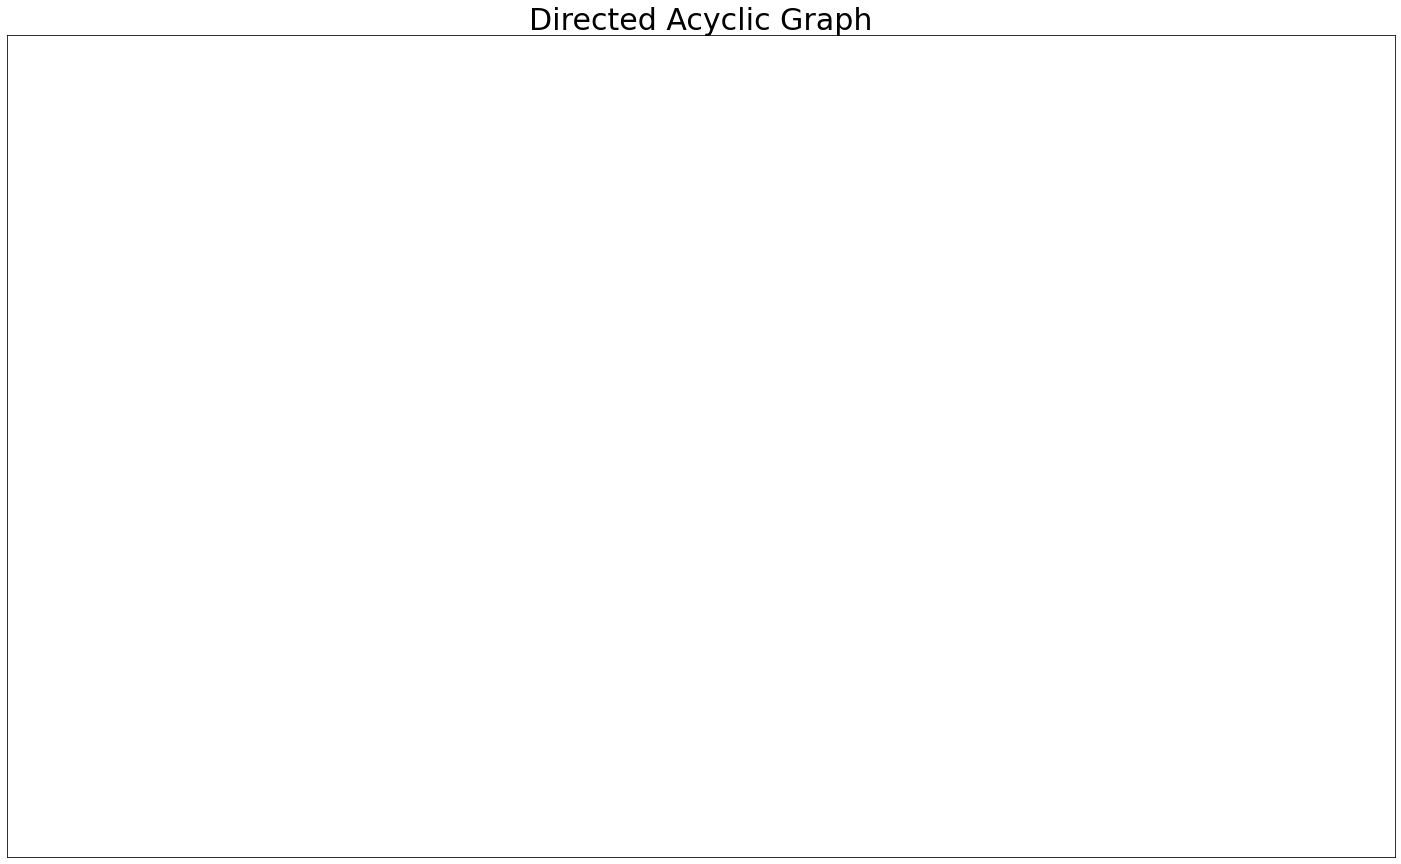

In [43]:
## D-separation

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")

In [44]:
data = df

In [45]:
def firstLetterWord(str, num_chars = 3):
 
    result = ""
 
    # Traverse the string.
    v = True
    for i in range(len(str)):
         
        # If it is space, set v as true.
        if (str[i] == ' '):
            v = True
 
        # Else check if v is true or not.
        # If true, copy character in output
        # string and set v as false.
        elif (str[i] != ' ' and v == True):
            result += (str[i:i+num_chars])
            v = False
 
    return result

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

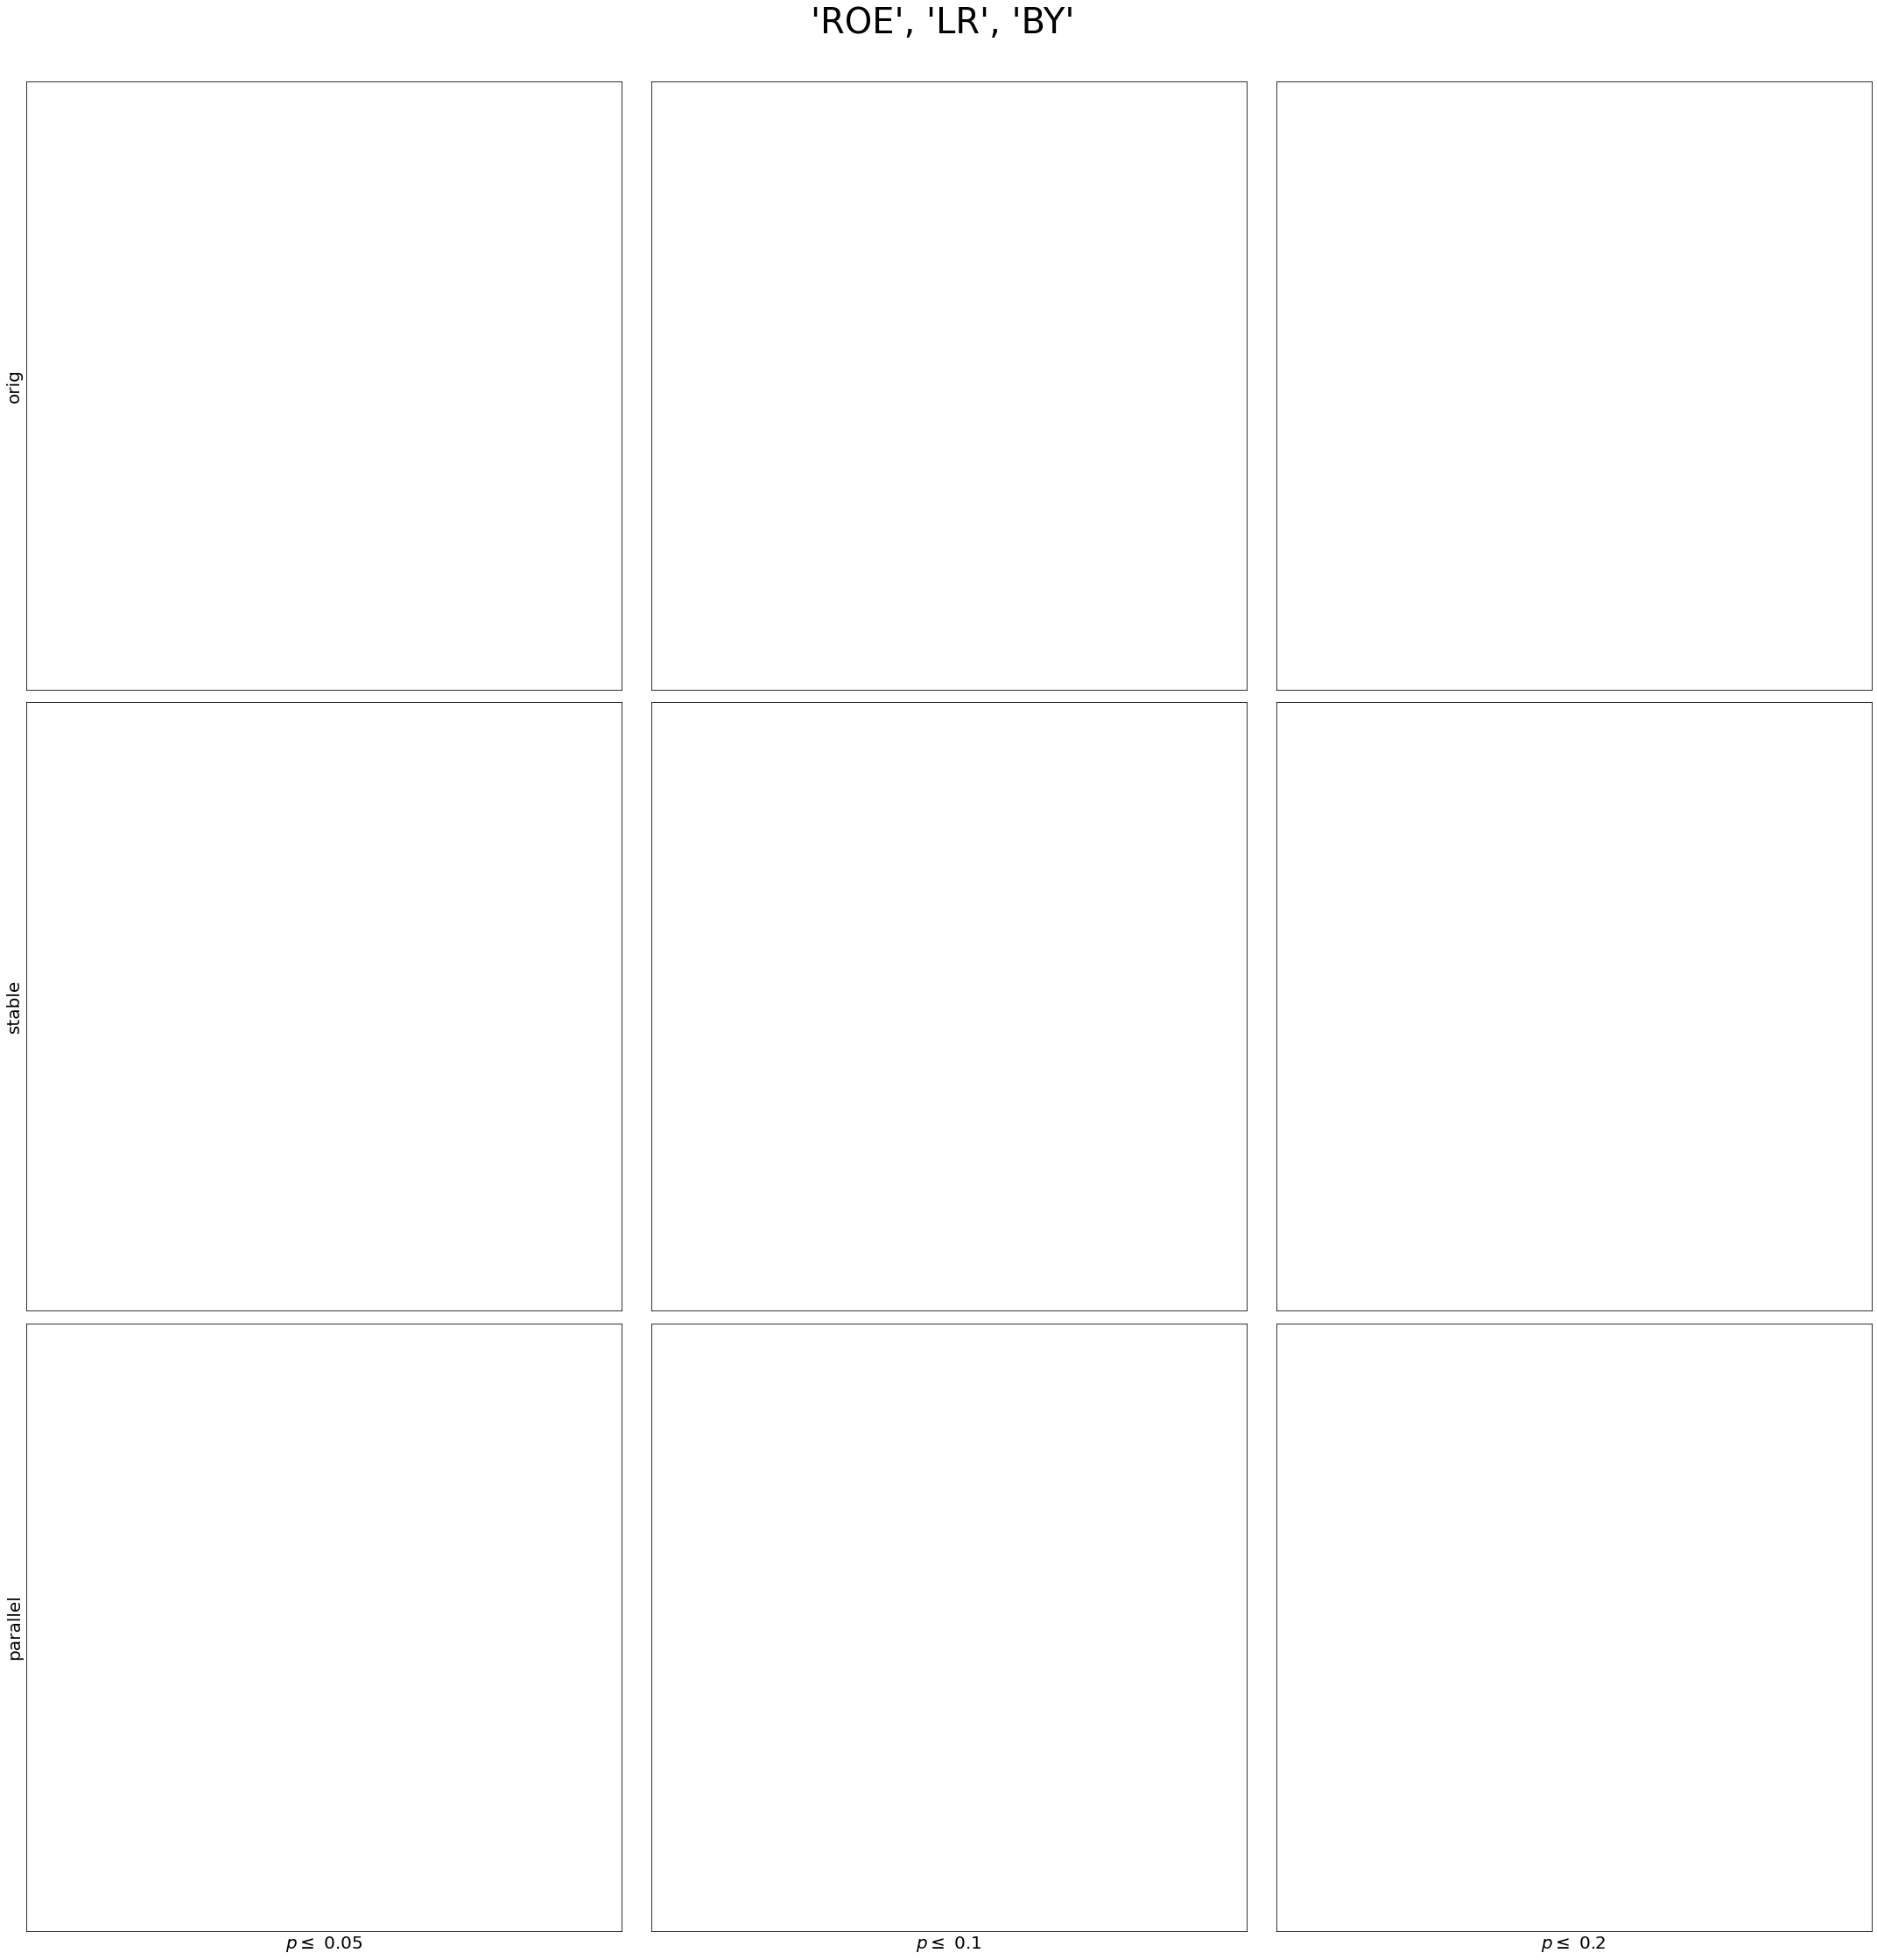

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

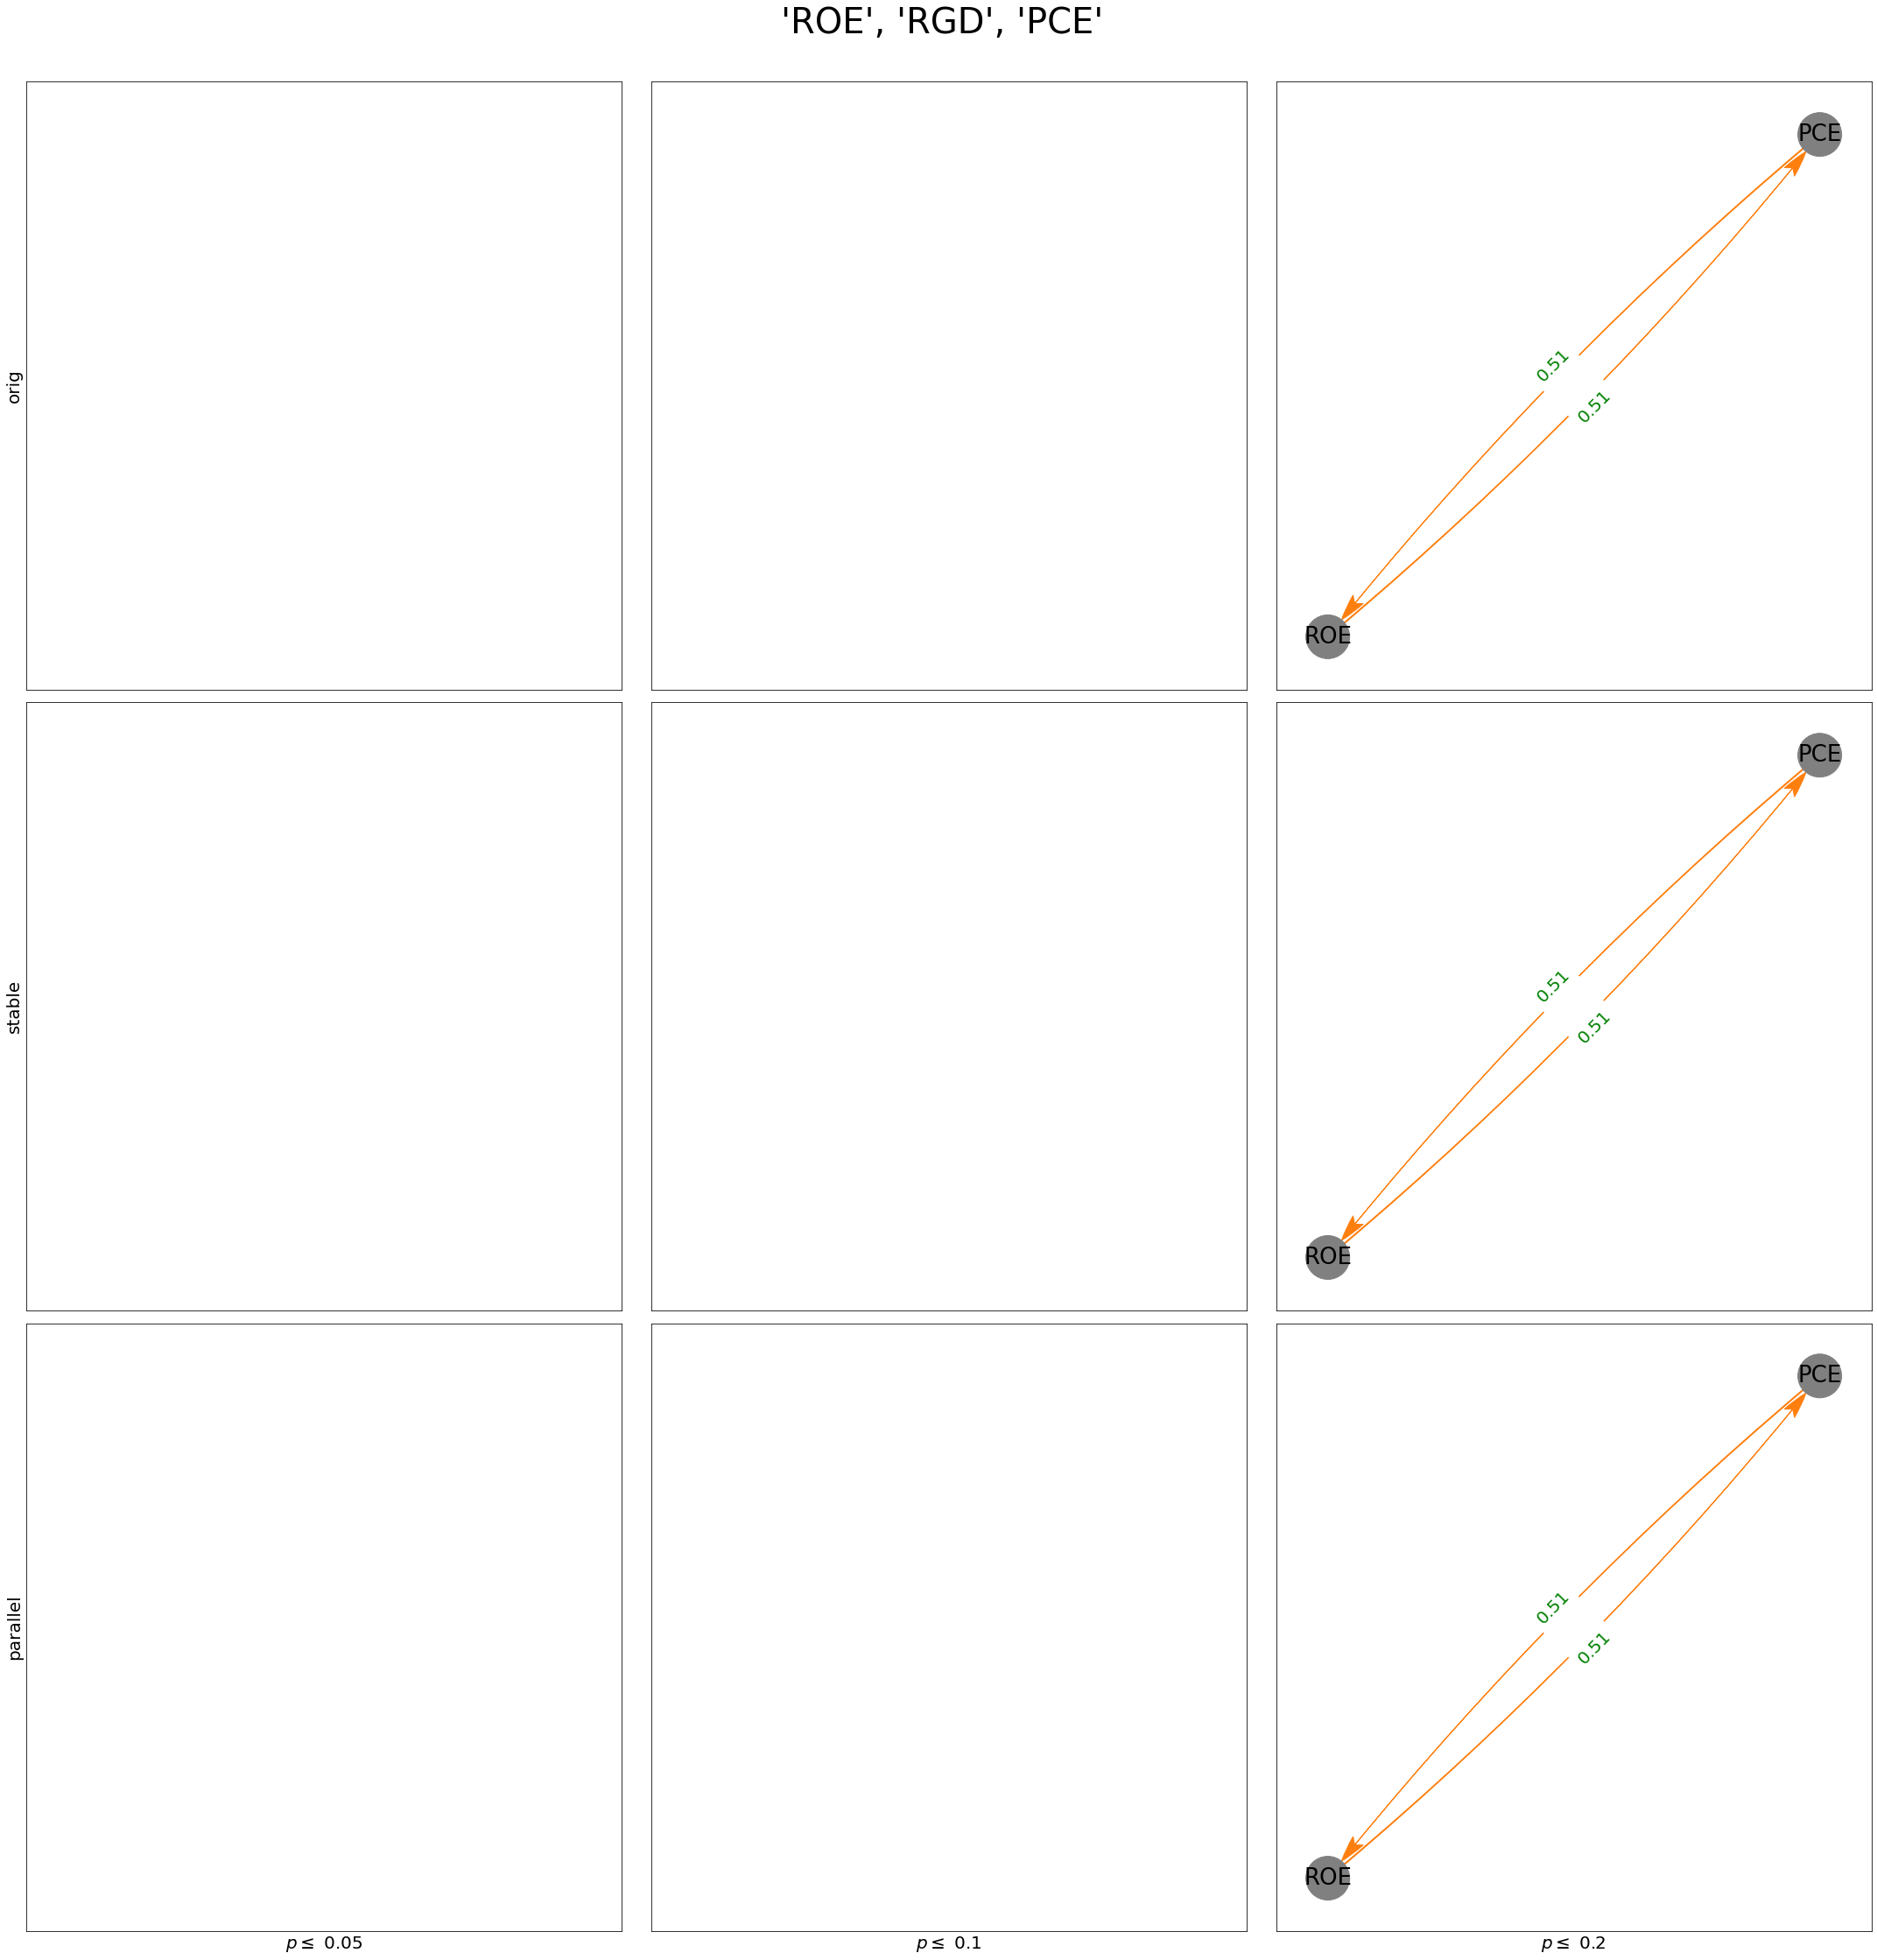

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

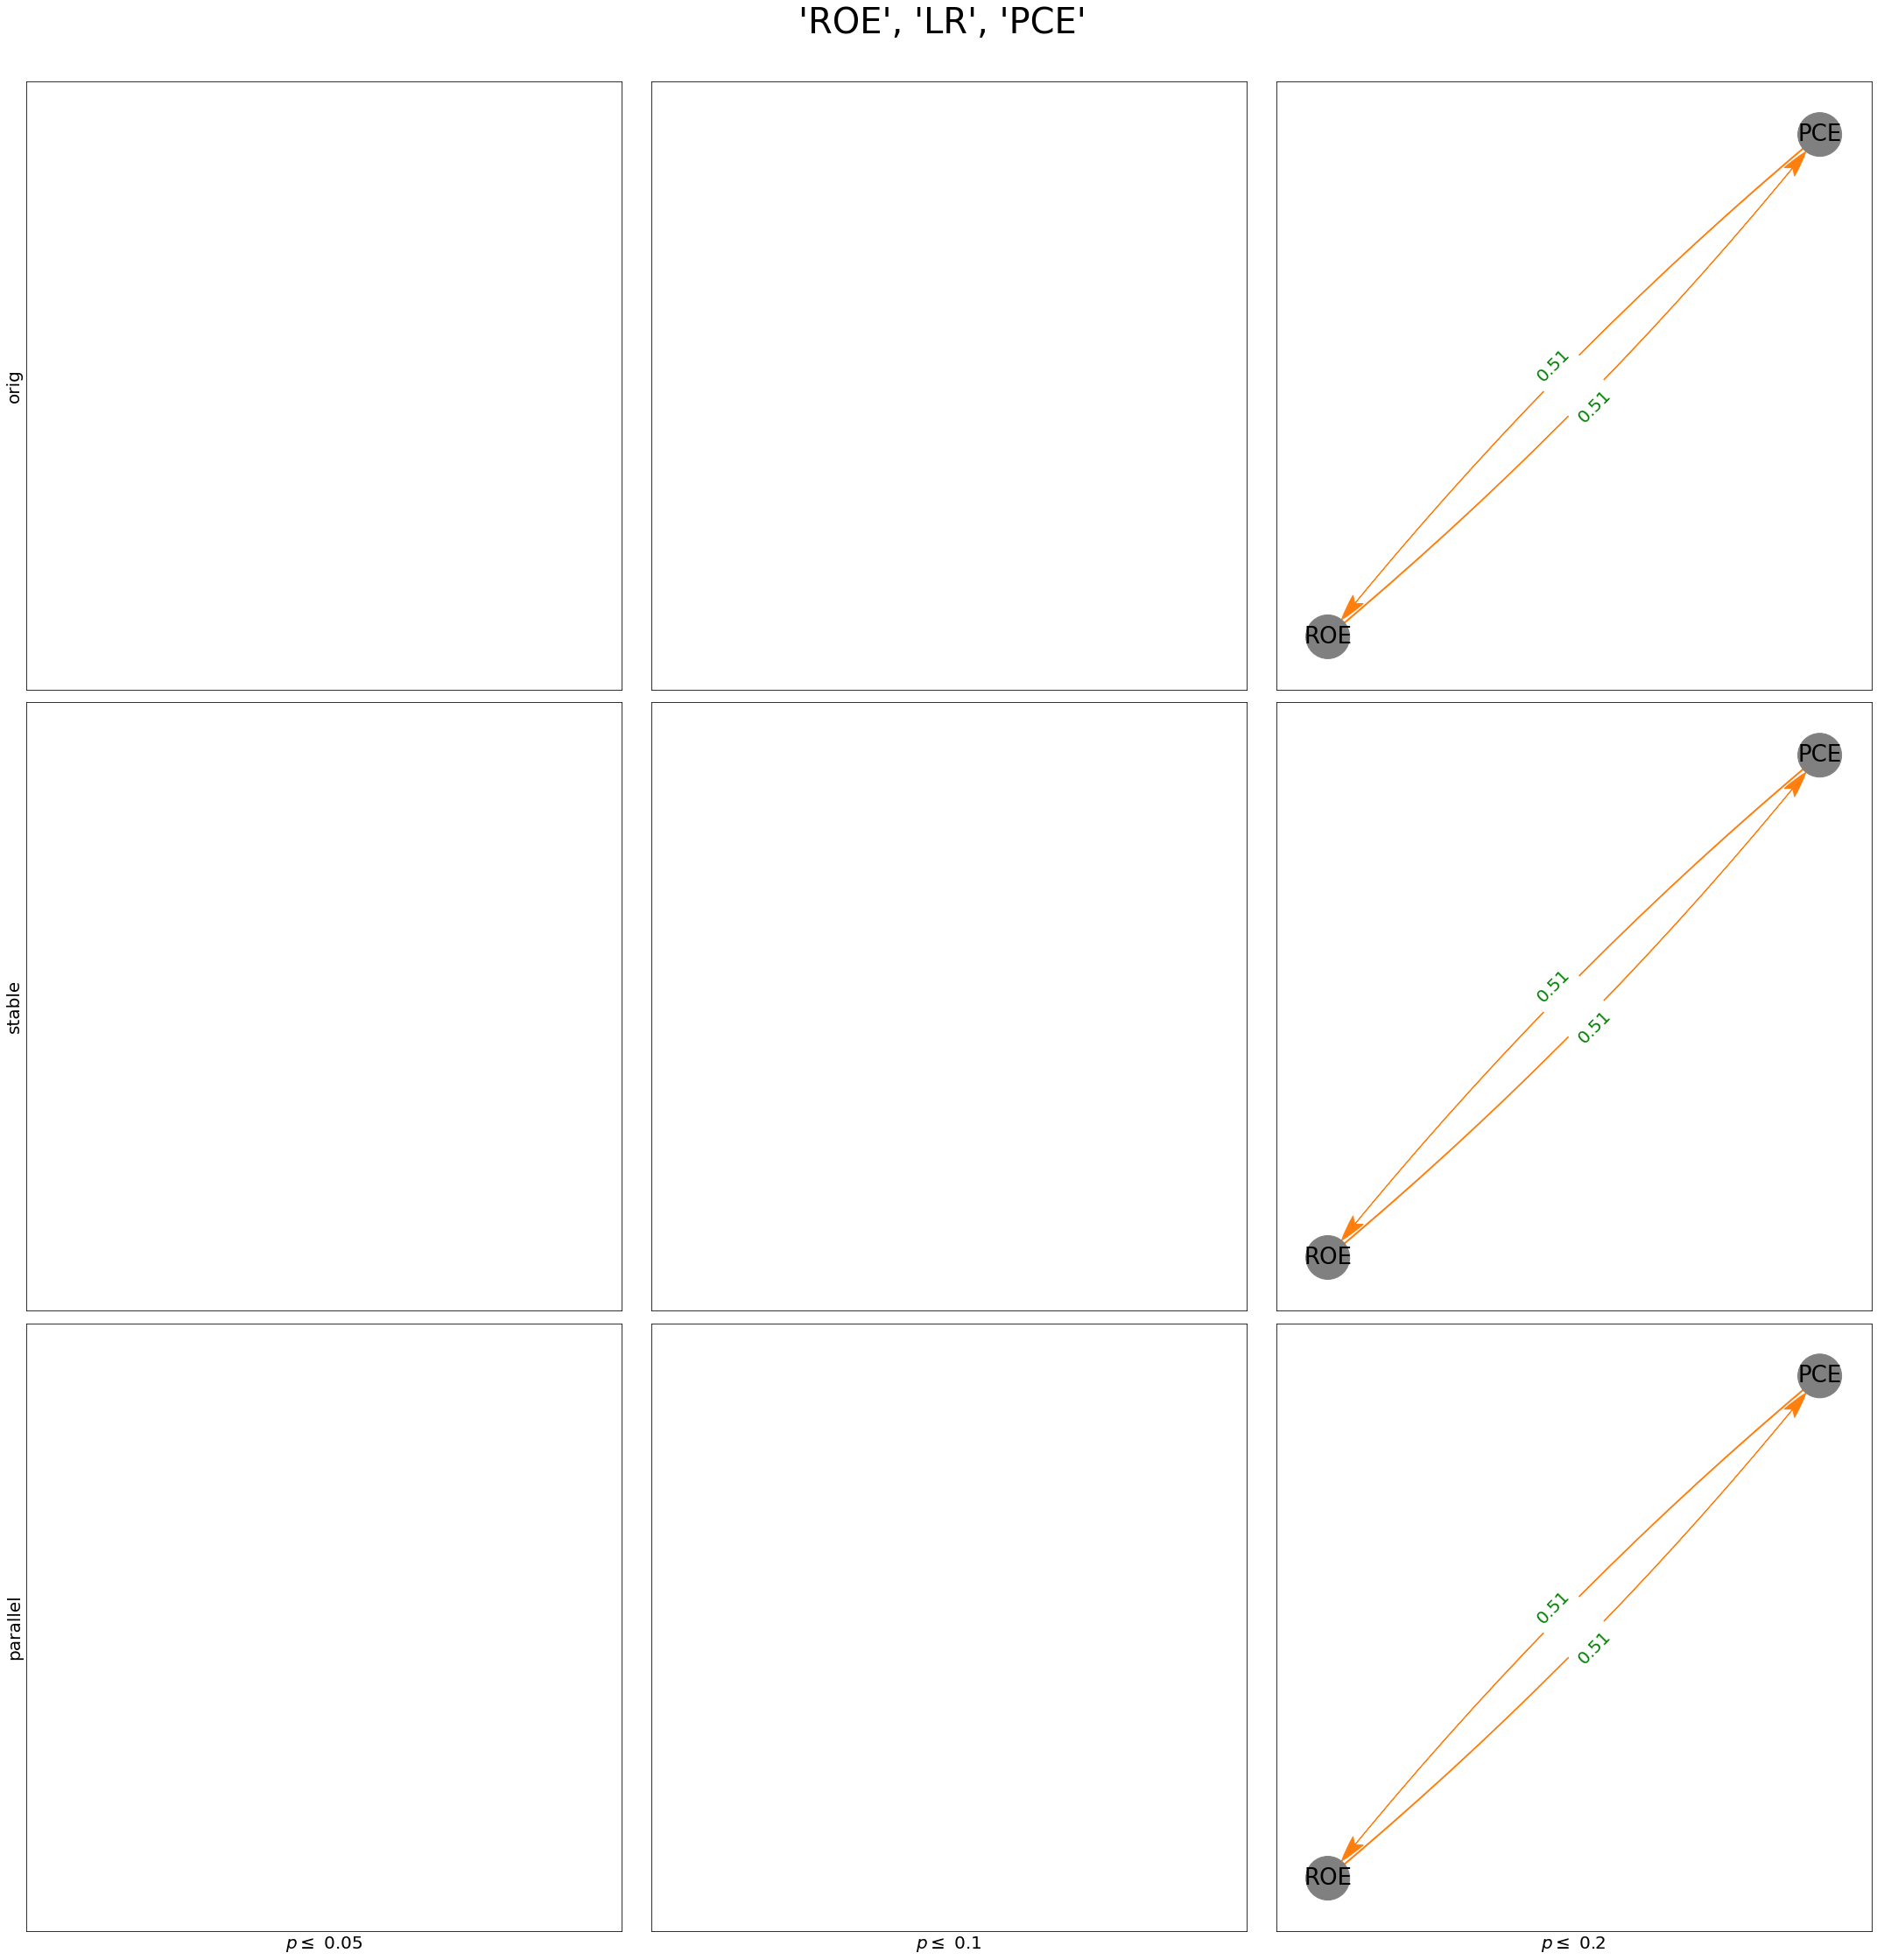

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

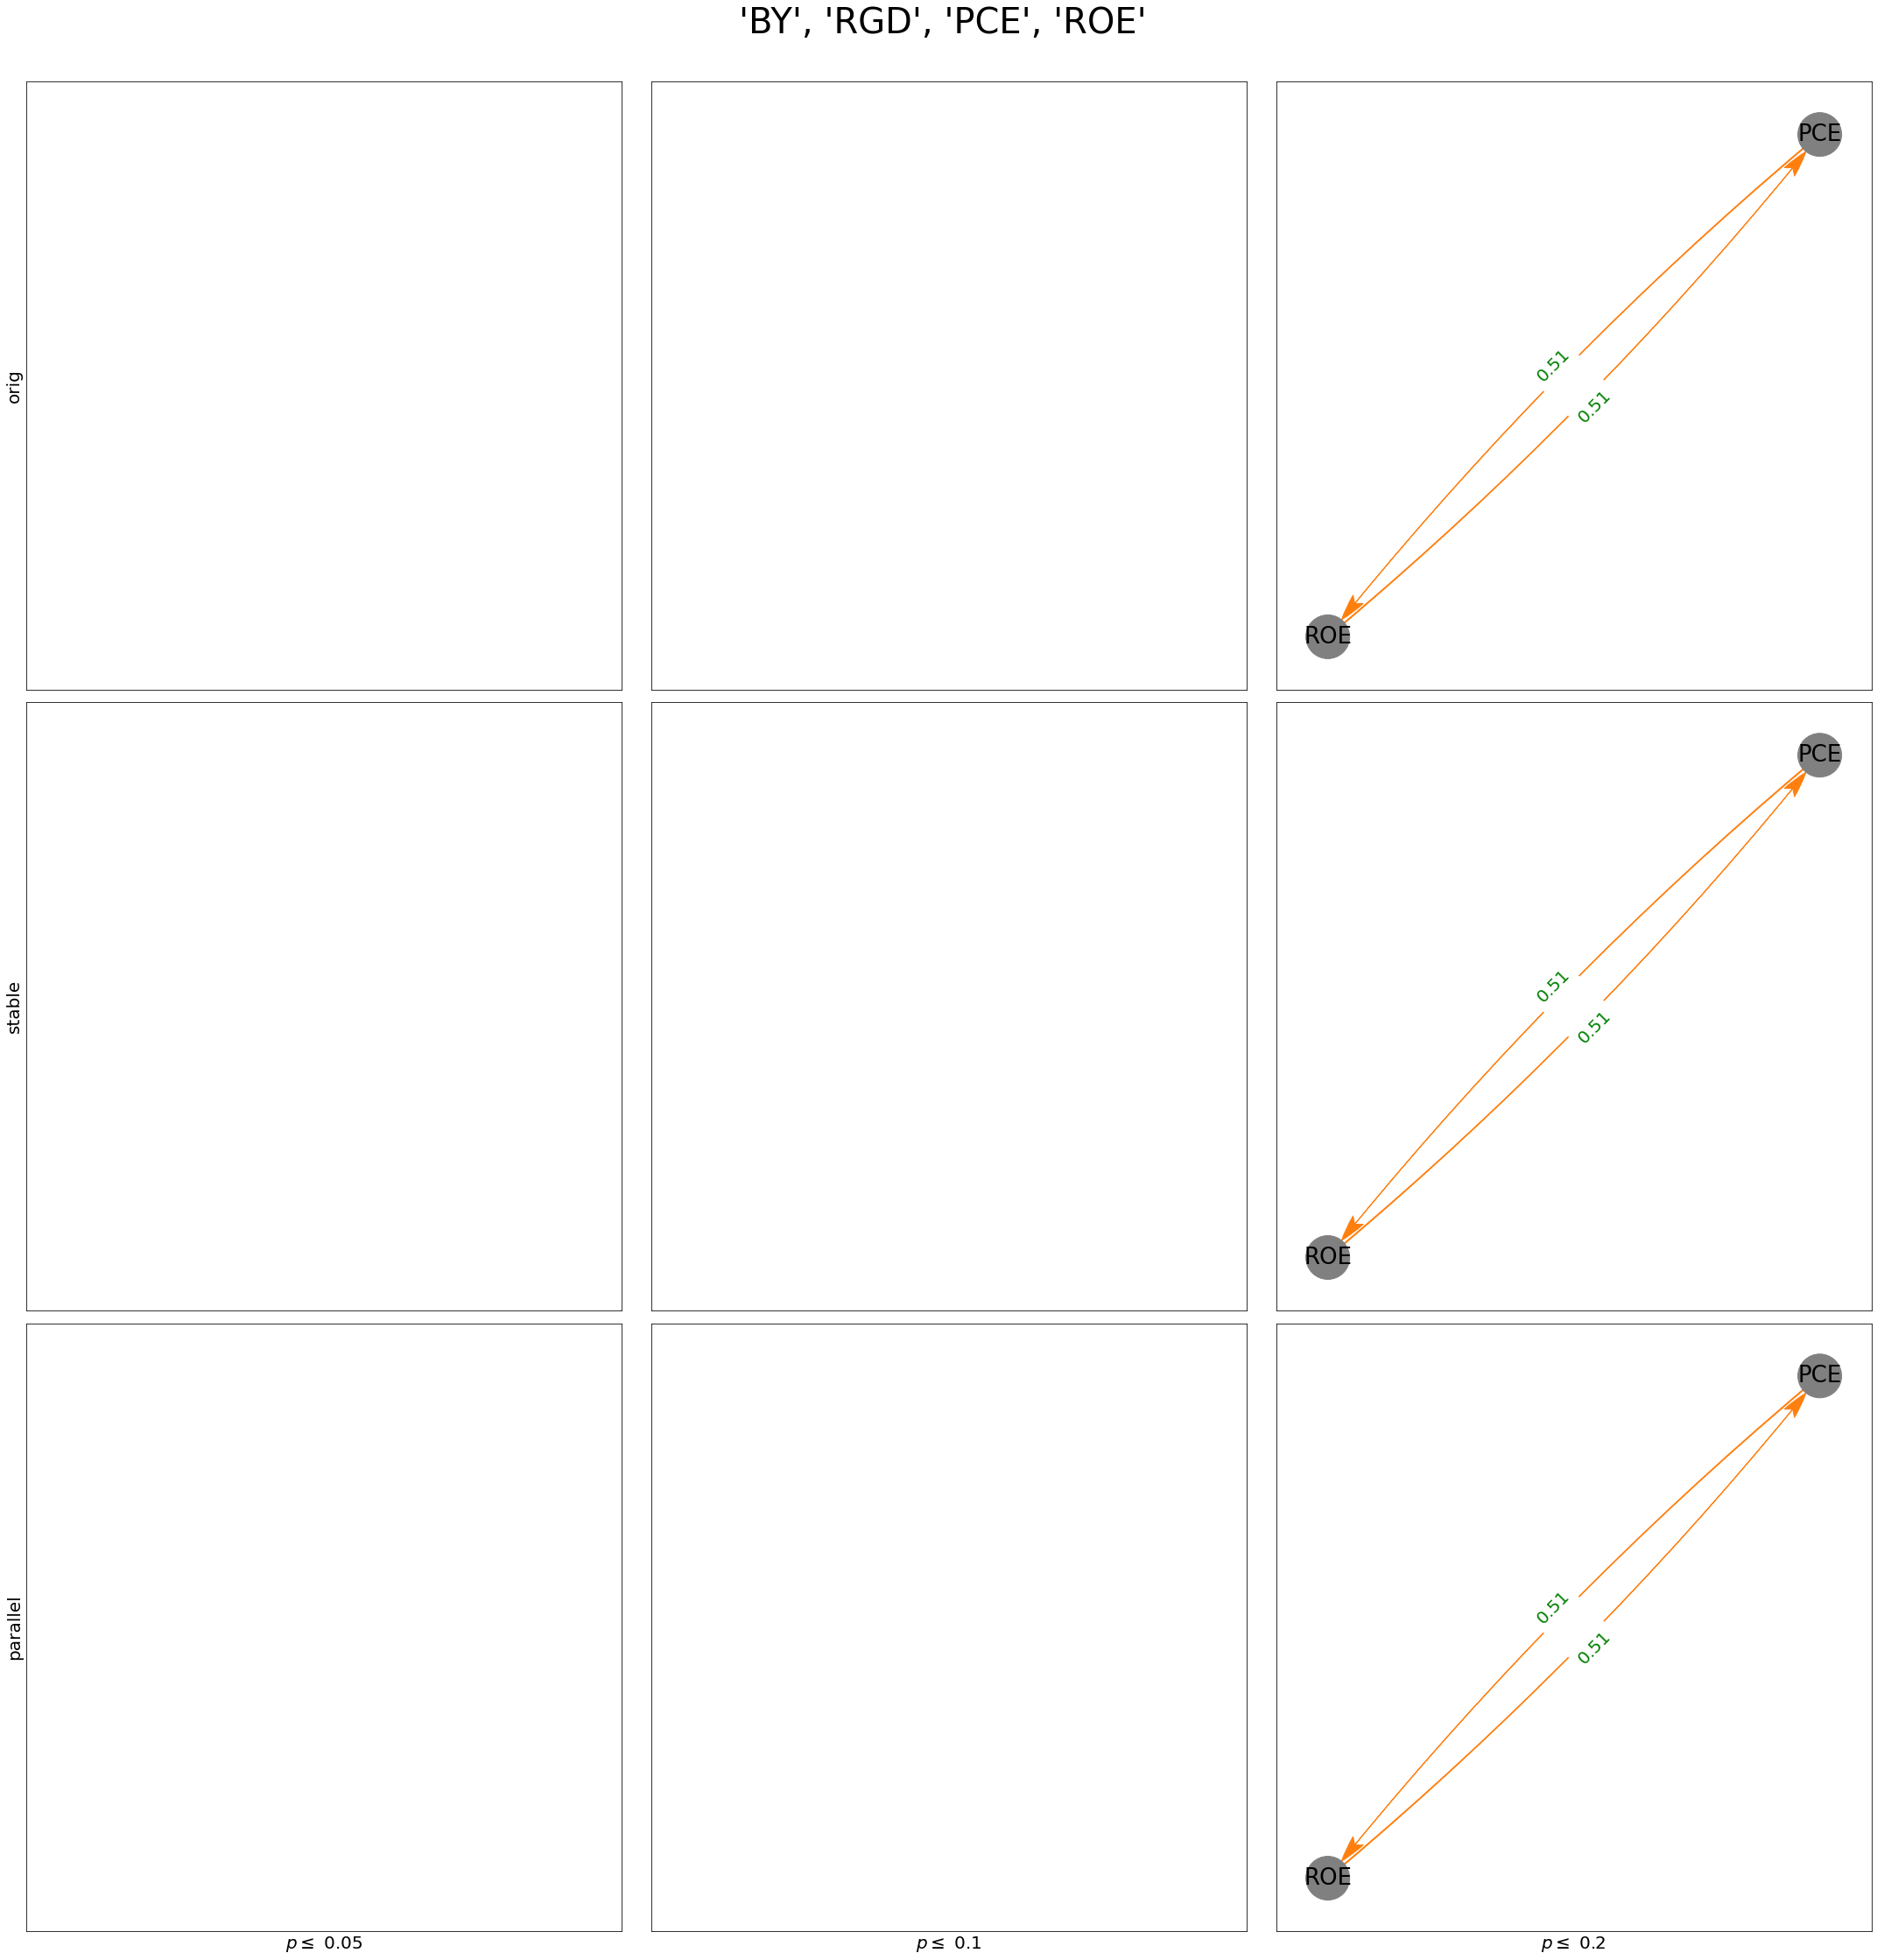

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

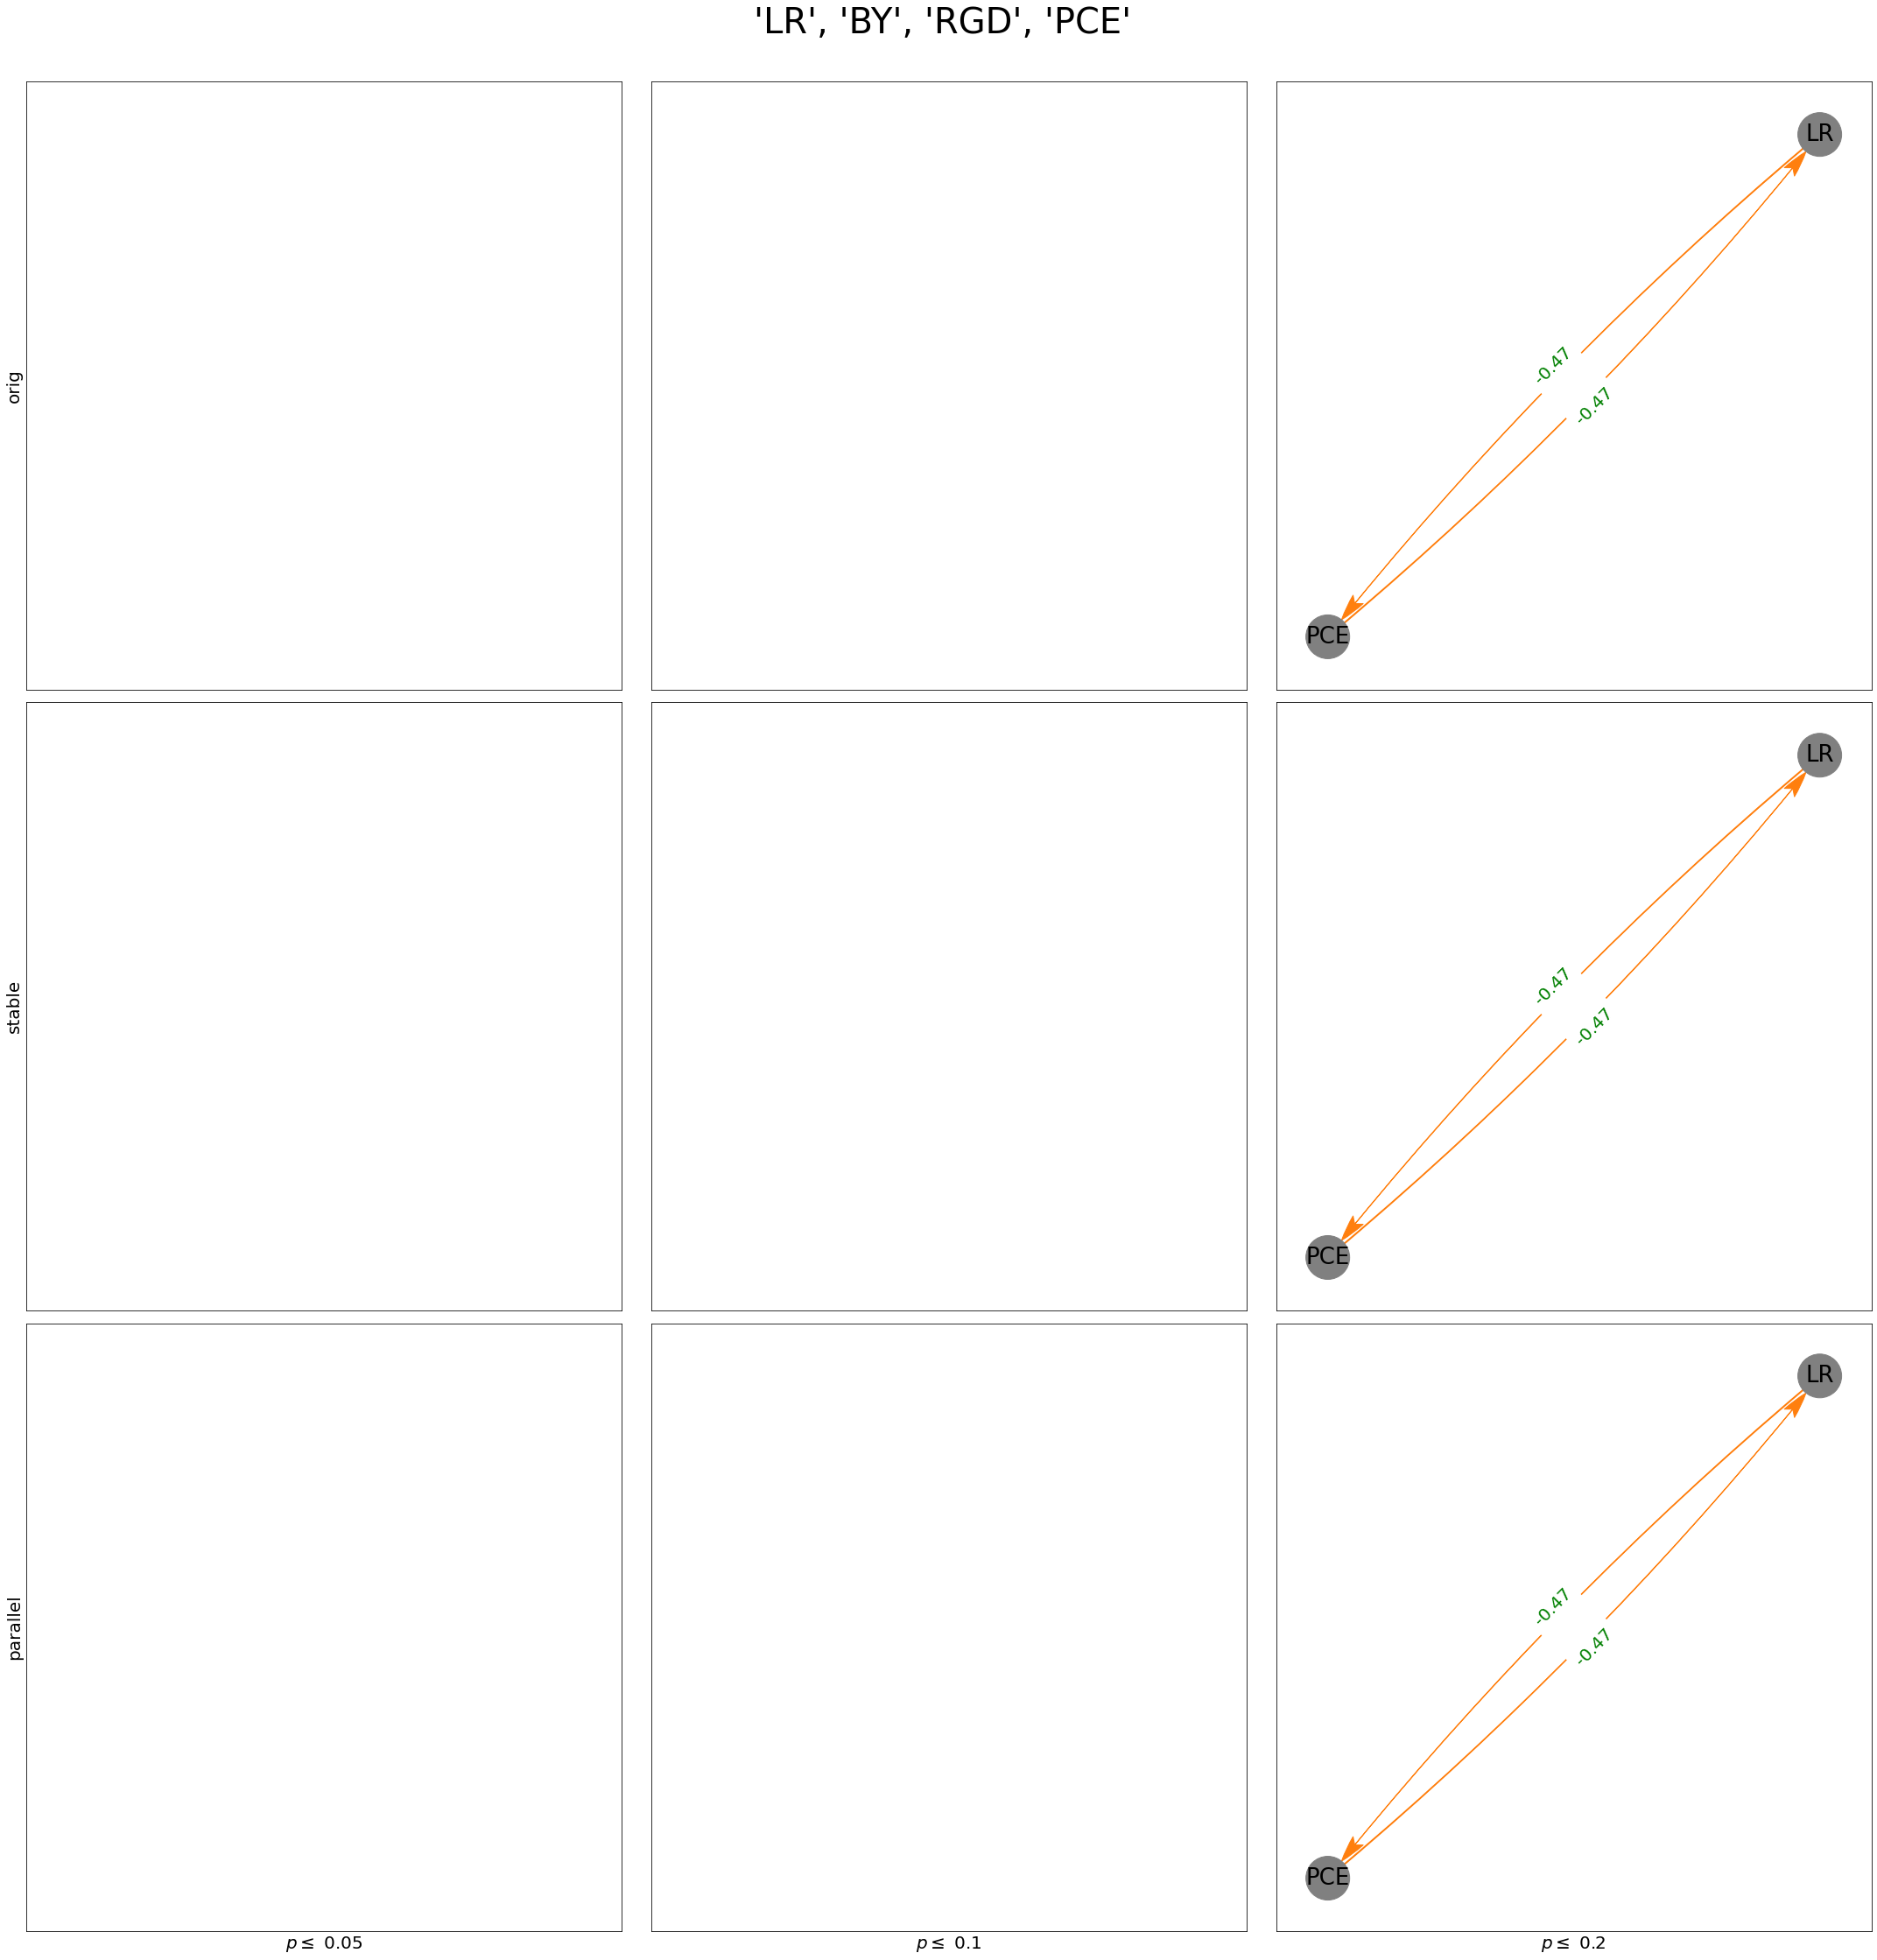

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

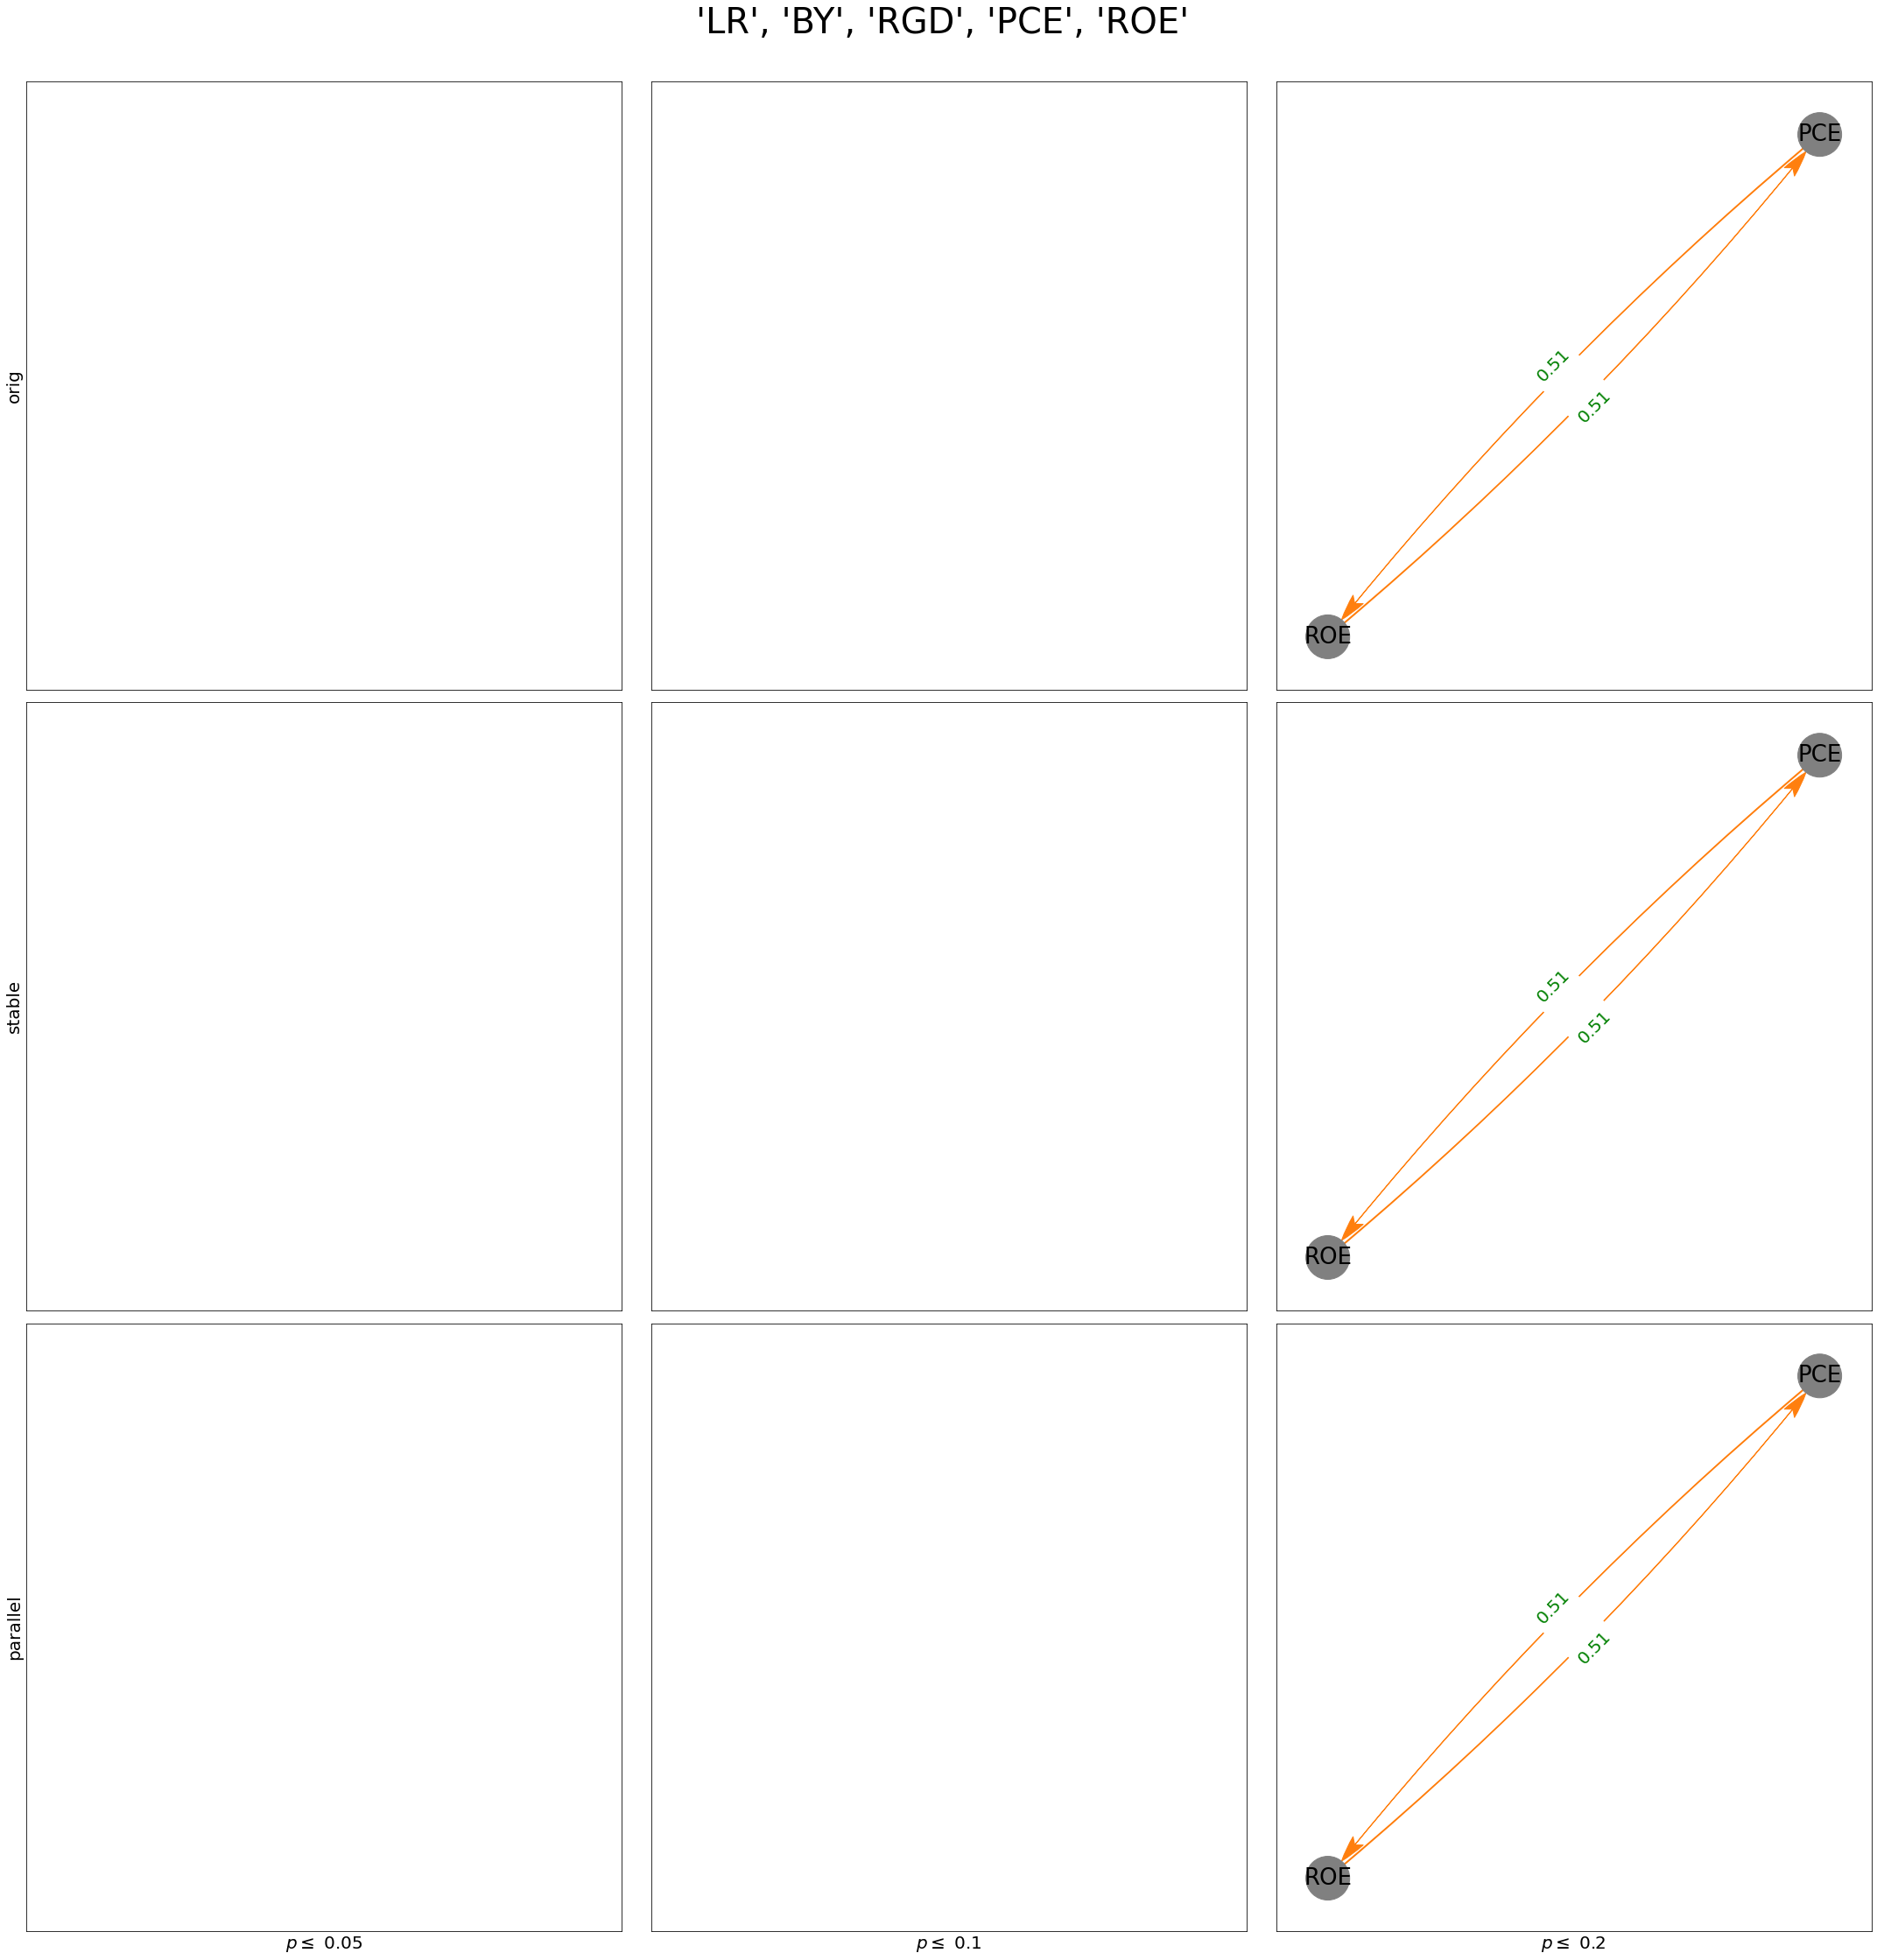

OutEdgeView([('ROE', 'PCE'), ('PCE', 'ROE')])

In [46]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["ROE", "LR", "BY"],
                  1:["ROE", "RGDP", "PCE"],
                  2:["ROE", "LR", "PCE"],
                  3:["BY", "RGDP", "PCE", "ROE"],
                  4:["LR", "BY", "RGDP", "PCE"],
                  5:["LR", "BY", "RGDP", "PCE", "ROE"],}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges